# MNIST Autoencoder Experiments
** March 2018 **

** Andrew Riberio @ [AndrewRib.com](http://www.andrewrib.com) **

Resources
* https://www.tensorflow.org/get_started/mnist/beginners
* https://blog.keras.io/building-autoencoders-in-keras.html

## 1. Libraries and Config

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import losses
from keras.callbacks import EarlyStopping
from tensorflow.examples.tutorials.mnist import input_data
from keras import backend as K
import tensorflow as tf
from ipywidgets import interact_manual,interact
import pandas as pd
from keras.models import load_model

#### 1.2. Start tensorflow session and have keras use it. 

In [13]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True,device_count = {'CPU' : 1, 'GPU' : 1}))
K.set_session(sess)

## 2. Gathering and Working with MNIST Data

#### 2.1. Loading the dataset object into the mnist variable and printing the dimensions of the data matrix and label vector. 

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
print("Shape of the image data matrix: {0}".format(mnist.train.images.shape))
print("Shape of the label data: {0}".format(mnist.train.labels.shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of the image data matrix: (55000, 784)
Shape of the label data: (55000,)


####  2.2. Visualizing an image in our training set. 

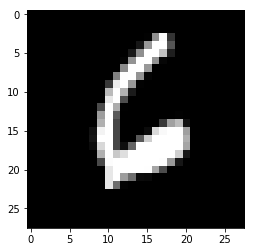

Image label: 6


In [4]:
exampleIndex = 3
exImage      = mnist.train.images[exampleIndex ,:]
exImageLabel = mnist.train.labels[exampleIndex]
plt.imshow(exImage.reshape(28,28),cmap='gray')
plt.show()
print("Image label: {0}".format(exImageLabel))

#### 2.3. Split images into digit class tensors.

In [5]:
# First we will zip the training labels with the training images
dataWithLabels = zip(mnist.train.labels, mnist.train.images)

# Now let's turn this into a dictionary where subsets of the images in respect 
# to digit class are stored via the corresponding key.

# Init dataDict with keys [0,9] and empty lists.
digitDict = {}
for i in range(0,10):
    digitDict[i] = []

# Assign a list of image vectors to each corresponding digit class index. 
for i in dataWithLabels:
    digitDict[i[0]].append(i[1])

# Convert the lists into numpy matricies. (could be done above, but I claim ignorace)
for i in range(0,10):
    digitDict[i] = np.matrix(digitDict[i])
    print("Digit {0} matrix shape: {1}".format(i,digitDict[i].shape))

Digit 0 matrix shape: (5444, 784)
Digit 1 matrix shape: (6179, 784)
Digit 2 matrix shape: (5470, 784)
Digit 3 matrix shape: (5638, 784)
Digit 4 matrix shape: (5307, 784)
Digit 5 matrix shape: (4987, 784)
Digit 6 matrix shape: (5417, 784)
Digit 7 matrix shape: (5715, 784)
Digit 8 matrix shape: (5389, 784)
Digit 9 matrix shape: (5454, 784)


## 3. Anomoly Detection for Non-Zero Class Digits

#### 3.1. Compile a simple single layer non-convolutional autoencoder for the digit class 0. 

In [31]:
def simpleAE(encoding_dim = 32, input_dim = 784):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    return Model(input_img, decoded)

In [32]:
ae1 = simpleAE(64,784)
ae1.compile(optimizer='adadelta', loss='binary_crossentropy')

#### 3.2. Train the autoencoder and log the loss over epoch history. 

In [14]:
modelURI = "models/mnist_zero_autoencoder_1_64.h5"

print("Loading model...")

try:
    # Load model if found. 
    ae1 = load_model(modelURI)
    print("Model found and loaded.")
except:
    # Train model if model cannot be loaded. 
    print("Model not found. Training model..")
    
    history = ae1.fit(digitDict[0], digitDict[0],
                    epochs=100,
                    batch_size=20,
                    shuffle=True,verbose=1)
    
    # Save our Model
    print("Model Saved.")
    ae1.save(modelURI)
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Loading model...
Model found and loaded.


#### 3.3. Explore trained autoencoder reconstruction results ( Interactive )

In [34]:
def dispRes1(digitClass=0,nthDigit=0):
    actual = digitDict[digitClass][nthDigit,:]
    pred = ae1.predict(actual)
    res = losses.mean_absolute_error(actual,pred)
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Mean Absolute Reconstruction Error: {0:.5}%".format(sess.run(res)[0]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(actual.reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(pred.reshape(28,28),cmap="gray")
    
    plt.show()
    
interact_manual(dispRes1,digitClass=(0,9),nthDigit=(0,1000))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), IntSlider(value=0, description='nthDigit', max=1000), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.dispRes1>

#### 3.4. Reconstruction Error Distributions ( Interactive )
We will now explore the reconstruction error distributions over the digit classes. 

In [35]:
classLosses = []
for digitClass in range(0,10):
    lossTensor = losses.mean_absolute_error(digitDict[digitClass],ae1.predict(digitDict[digitClass]))
    res = sess.run(lossTensor)
    res.sort()
    classLosses.append(res)

In [36]:
def dispDists(digitClass=0):
    l = len(classLosses[digitClass])
    plt.figure(figsize=(6, 6))
    plt.hist(classLosses[digitClass],bins=20,range=(0, 0.125))
    plt.show()
    
interact(dispDists,digitClass=(0,9))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.dispDists>

We will now plot the histograms of the reconstruction error distributions over the digit classes.

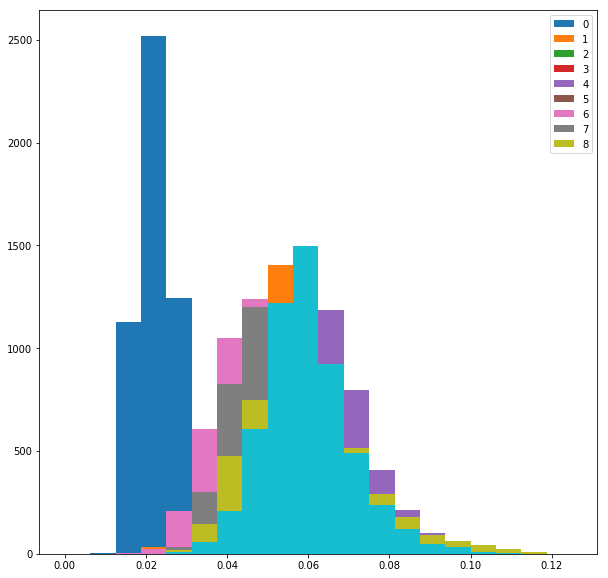

In [37]:
plt.figure(figsize=(10, 10))
for digitClass in range(0,10):
    l = len(classLosses[digitClass])
    plt.legend(['0','1','2','3','4','5','6','7','8','9'], loc='upper right')
    plt.hist(classLosses[digitClass],bins=20,range=(0, 0.125))
plt.show()

In [38]:
# Summary Statistics for Digit Reconstruction Loss
pd.DataFrame(classLosses).transpose().describe()

,0,1,2,3,4,5,6,7,8,9
count,5444.000000,6179.000000,5470.000000,5638.000000,5307.000000,4987.000000,5417.000000,5715.000000,5389.000000,5454.000000
mean,0.023555,0.050618,0.060406,0.052698,0.064543,0.055918,0.048636,0.054238,0.059698,0.059719
std,0.006048,0.011172,0.012814,0.013837,0.011656,0.012653,0.011189,0.012223,0.014361,0.010814
min,0.011773,0.014641,0.022195,0.021558,0.031291,0.024523,0.017317,0.025370,0.020200,0.025546
25%,0.019330,0.042684,0.051233,0.042509,0.057116,0.047245,0.040849,0.045301,0.049665,0.052791
50%,0.022452,0.050653,0.060306,0.050756,0.063328,0.054275,0.047860,0.052630,0.058125,0.058717
75%,0.026556,0.057630,0.069113,0.060987,0.070706,0.062614,0.055148,0.061687,0.067644,0.065478
max,0.060401,0.113417,0.114180,0.113039,0.123094,0.120863,0.103828,0.109914,0.130665,0.120293


#### 3.5. Classify reconstruction loss. 
**3.5.1. Create loss classifier network architecture **

In [39]:
def simpleNN(encoding_dim = 10, input_dim = 1):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(1, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    return Model(input_img, decoded)

**3.5.2. Preprocess data for classifier**

In [40]:
# Preprocess Data for Classifier
zeroClass = classLosses[0]
otherClass = np.concatenate(classLosses[1:10])
labels = np.concatenate([np.zeros(len(zeroClass)),np.ones(len(otherClass))])
data = np.concatenate([zeroClass,otherClass])

**3.5.3. Train loss classifier**

Loading model...
Model not found. Training model..
Epoch 1/25
55000/55000 [==============================] - 16s 285us/step - loss: 0.3116
Epoch 2/25
55000/55000 [==============================] - 2s 36us/step - loss: 0.2381
Epoch 3/25
55000/55000 [==============================] - 2s 36us/step - loss: 0.1450
Epoch 4/25
55000/55000 [==============================] - 2s 35us/step - loss: 0.0954
Epoch 5/25
55000/55000 [==============================] - 2s 33us/step - loss: 0.0792
Epoch 6/25
55000/55000 [==============================] - 2s 34us/step - loss: 0.0725
Epoch 7/25
55000/55000 [==============================] - 2s 34us/step - loss: 0.0690
Epoch 8/25
55000/55000 [==============================] - 2s 35us/step - loss: 0.0669
Epoch 9/25
55000/55000 [==============================] - 2s 35us/step - loss: 0.0656
Epoch 10/25
55000/55000 [==============================] - 2s 34us/step - loss: 0.0647
Epoch 11/25
55000/55000 [==============================] - 2s 34us/step - loss: 0.0641

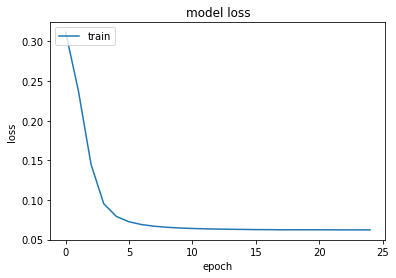

In [41]:
modelURI = "models/reconstruction_loss_1_64.h5"

print("Loading model...")

try:
    # Load model if found. 
    snn = load_model(modelURI)
    print("Model found and loaded.")
except:
    # Train model if model cannot be loaded. 
    print("Model not found. Training model..")
    
    snn = simpleNN()
    snn.compile(optimizer='adadelta', loss='binary_crossentropy')
    history = snn.fit(data, labels,
                        epochs=25,
                        batch_size=20,
                        shuffle=True,verbose=1)
    
    # Save our Model
    print("Model Saved.")
    snn.save(modelURI)
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


**3.5.4. Visualize results.**

In [17]:
def dispRes1(digitClass=0,nthDigit=0):
    classificationThresh = 0.5
    actual = digitDict[digitClass][nthDigit,:]
    pred = ae1.predict(actual)
    res = losses.mean_absolute_error(actual,pred)
    res = sess.run(res)
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Mean Absolute Reconstruction Error: {0:.5}%".format(res[0]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(actual.reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(pred.reshape(28,28),cmap="gray")
    
    plt.show()
    
    snnRes = snn.predict(res)[0][0]
    
    if snnRes < classificationThresh:
        print("Classification 0 : [{0}]".format( 1-snnRes ))
    else:
        print("Classification ANOMALY : [{0}]".format( snnRes ))
        
    
    
    
interact_manual(dispRes1,digitClass=(0,9),nthDigit=(0,1000))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), IntSlider(value=0, description='nthDigit', max=1000), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.dispRes1>

**3.5.5. Evaluate the classification accuracy**

In [42]:
classificationThresh = 0.5

# Get all the training images. 
actual = mnist.train.images

# Pass all the images through the trained zero digit autoencoder. 
pred = ae1.predict(actual)

# Calculuate the reconstruction loss for each image passed through the autoencoder. 
res = losses.mean_absolute_error(actual,pred)

# Use tensorflow to compute the value. 
res = sess.run(res)

# Pass the losses through the loss classifier. 
snnRes = snn.predict(res)

In [43]:
def tresholdFn( loss ):
    if loss < classificationThresh:
        return 0
    else:
        return 1

predictions = np.vectorize(tresholdFn)(snnRes)

In [44]:
nData = mnist.train.labels.shape[0]
nFalsePos = 0
falsePosIdxs = []
nFalseNeg = 0
falseNegIdxs = []

for index,prediction,label,in zip(range(nData),predictions,mnist.train.labels):
    # Compute the number of false negatives. 
    if label == 0 and prediction == 1:
        nFalseNeg += 1
        falseNegIdxs.append(index)
        
    # Compute the number of false positives. 
    if label != 0 and prediction == 0:
        nFalsePos += 1
        falsePosIdxs.append(index)
    
print("Number of false negatives: {0}".format(nFalseNeg))
print("Percentage of false negatives: {0:.3}%".format(nFalseNeg/digitDict[0].shape[0]*100))
print("---")
print("Number of false positives: {0}".format(nFalsePos))
print("Percentage of false positives: {0:.6}%".format(nFalsePos/otherClass.shape[0]*100))

Number of false negatives: 554
Percentage of false negatives: 10.2%
---
Number of false positives: 684
Percentage of false positives: 1.38026%


In [22]:
autoResults = ae1.predict(mnist.train.images)
lossRes = losses.mean_absolute_error(mnist.train.images,autoResults)
lossRes = sess.run(lossRes)

Visualize False Positives. False positives are non-zero characters that are classified as zeros. 

In [45]:
def displayFalsePos(idx = 0):
    classificationThresh = 0.5
    
    indexVis = falsePosIdxs[idx]
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("False Positives - Mean Absolute Reconstruction Error: {0:.5}%".format(lossRes[indexVis]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(mnist.train.images[indexVis,:].reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(autoResults[indexVis,:].reshape(28,28),cmap="gray")
    
    plt.show()
    
    print("Absolute index value: {0}.".format(indexVis))
    print("Image label: {0}.".format(mnist.train.labels[indexVis]))
        
interact(displayFalsePos,idx = (0,len(falsePosIdxs)-1))

interactive(children=(IntSlider(value=0, description='idx', max=683), Output()), _dom_classes=('widget-interact',))

<function __main__.displayFalsePos>

In [46]:
def displayFalseNeg(idx = 0):
    classificationThresh = 0.5
    
    indexVis = falseNegIdxs[idx]
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("False Negatives - Mean Absolute Reconstruction Error: {0:.5}%".format(lossRes[indexVis]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(mnist.train.images[indexVis,:].reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(autoResults[indexVis,:].reshape(28,28),cmap="gray")
    
    plt.show()
    
    print("Absolute index value: {0}.".format(indexVis))
    print("Image label: {0}.".format(mnist.train.labels[indexVis]))
        
interact(displayFalseNeg,idx = (0,len(falseNegIdxs)-1))

interactive(children=(IntSlider(value=0, description='idx', max=553), Output()), _dom_classes=('widget-interact',))

<function __main__.displayFalseNeg>

Number of false negatives: 757
Percentage of false negatives: 13.9%
---
Number of false positives: 394
Percentage of false positives: 0.79506%